In [2]:
from sklearn.datasets import fetch_openml


X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [3]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

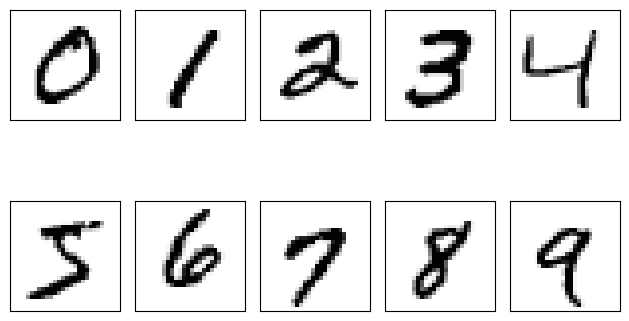

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_4.png', dpi=300)
plt.show()

Visualize 25 different versions of "7":

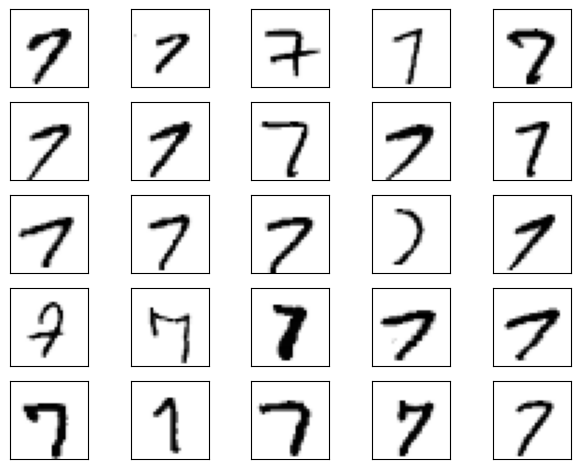

In [5]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [6]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

<br>
<br>

## Implementing a multi-layer perceptron

In [7]:
import numpy as np

In [8]:
##########################
### MODEL
##########################

def sigmoid(z):
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

def softmax(z):
    exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary


class NeuralNetMLP:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)
        
        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = softmax(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):  
    
        #########################
        ### Output layer weights
        #########################
        
        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use
        
        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights
        
        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h
        
        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)
        

        #################################        
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight
        
        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out
        
        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)
        
        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative
        
        # [n_examples, n_features]
        d_z_h__d_w_h = x
        
        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__d_w_h, d_loss__d_b_h)

In [9]:
model = NeuralNetMLP(num_features=28*28,
                     num_hidden=500,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [10]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size 
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]
        
        yield X[batch_idx], y[batch_idx]

        
# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)
    
    for X_train_mini, y_train_mini in minibatch_gen:

        break
        
    break
    
print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [11]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets) 


_, probas = model.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.1
Initial validation accuracy: 10.5%


In [12]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)
        
        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()
        
        num_examples += targets.shape[0]
        mse += loss


    mse = mse/(i+1)
    acc = correct_pred/num_examples
    
    return mse, acc

In [13]:
from sklearn.metrics import roc_auc_score
import numpy as np

def compute_macro_auc(nnet, X, y, num_labels=10, minibatch_size=100):
    """
    Computes the Macro-averaged Area Under the ROC Curve.
    """
    all_probas = []
    all_targets = []
    
    # Use the minibatch generator to handle large datasets efficiently
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for features, targets in minibatch_gen:
        # Note: Unpacking 3 values for your 2-hidden layer architecture
        # (a_h, a_h2, a_out)
        _, probas = nnet.forward(features)
        
        all_probas.append(probas)
        all_targets.append(targets)

    # Concatenate all batch results into single arrays
    y_true_combined = np.concatenate(all_targets)
    y_probas_combined = np.concatenate(all_probas)

    # Calculate Macro AUC using One-vs-Rest (ovr) strategy
    macro_auc = roc_auc_score(
        y_true_combined, 
        y_probas_combined, 
        multi_class='ovr', 
        average='macro'
    )
    
    return macro_auc

In [14]:
mse, acc = compute_mse_and_acc(model, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')
auc = compute_macro_auc(model, X_valid, y_valid)
print(f'Initial valid Macro AUC: {auc:.3f}')

Initial valid MSE: 0.1
Initial valid accuracy: 10.5%
Initial valid Macro AUC: 0.478


In [15]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = \
                model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        valid_auc = compute_macro_auc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Valid AUC: {valid_auc:.3f}')


    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [16]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model, X_train, y_train, X_valid, y_valid,
    num_epochs=20, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.04 | Train Acc: 75.86% | Valid Acc: 75.64%| Valid AUC: 0.973
Epoch: 002/020 | Train MSE: 0.03 | Train Acc: 81.14% | Valid Acc: 80.93%| Valid AUC: 0.982
Epoch: 003/020 | Train MSE: 0.03 | Train Acc: 82.15% | Valid Acc: 81.82%| Valid AUC: 0.983
Epoch: 004/020 | Train MSE: 0.02 | Train Acc: 82.89% | Valid Acc: 82.46%| Valid AUC: 0.984
Epoch: 005/020 | Train MSE: 0.02 | Train Acc: 89.67% | Valid Acc: 89.12%| Valid AUC: 0.989
Epoch: 006/020 | Train MSE: 0.02 | Train Acc: 90.12% | Valid Acc: 89.67%| Valid AUC: 0.991
Epoch: 007/020 | Train MSE: 0.02 | Train Acc: 90.28% | Valid Acc: 89.87%| Valid AUC: 0.990
Epoch: 008/020 | Train MSE: 0.02 | Train Acc: 88.39% | Valid Acc: 88.33%| Valid AUC: 0.988
Epoch: 009/020 | Train MSE: 0.03 | Train Acc: 84.27% | Valid Acc: 84.01%| Valid AUC: 0.986
Epoch: 010/020 | Train MSE: 0.03 | Train Acc: 84.74% | Valid Acc: 84.67%| Valid AUC: 0.985
Epoch: 011/020 | Train MSE: 0.03 | Train Acc: 81.41% | Valid Acc: 81.54%| Valid AUC: 0.985

## Evaluating the neural network performance

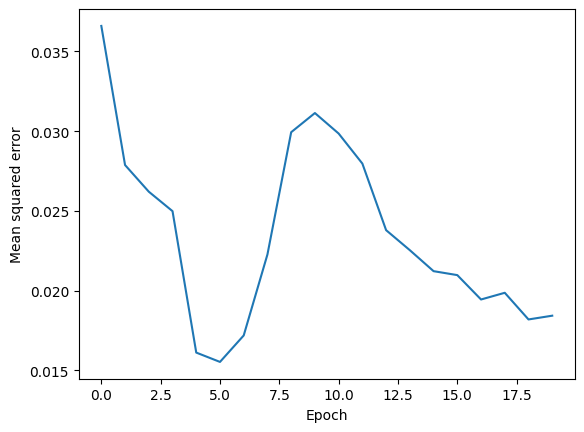

In [17]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

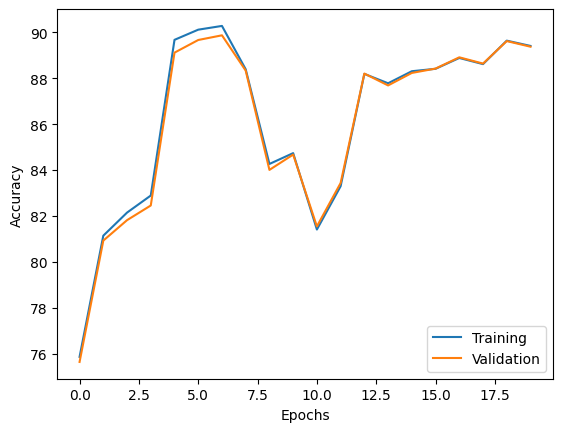

In [18]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [19]:
test_mse, test_acc = compute_mse_and_acc(model, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')

Test accuracy: 89.06%


Plot failure cases:

In [20]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, probas = model.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

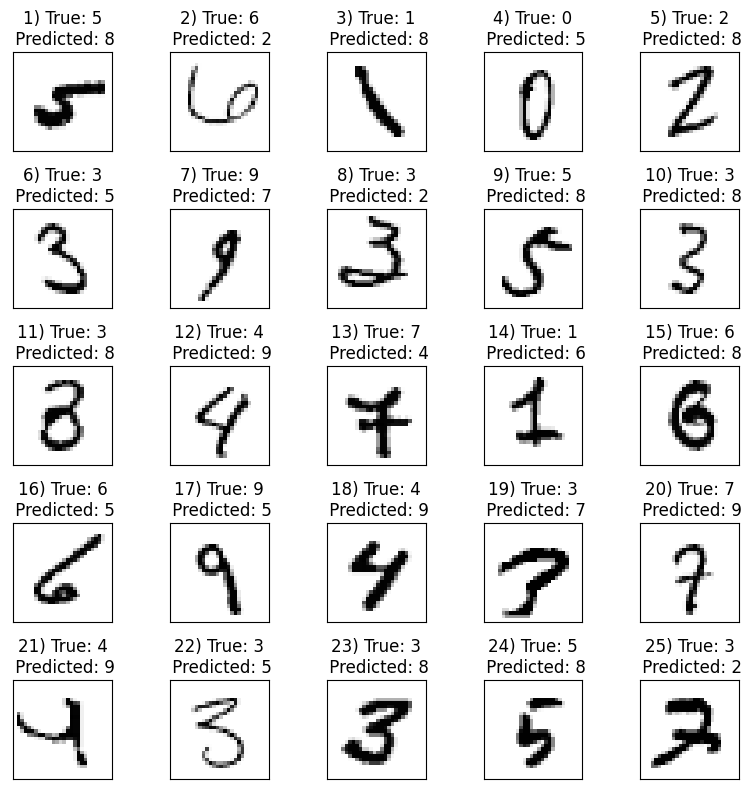

In [21]:
fig, ax = plt.subplots(nrows=5, ncols=5, 
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

In [25]:
import numpy as np
import sys
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score

# ==========================================
# Task 1 & 2: NeuralNetMLP with 2 Hidden Layers
# ==========================================

def softmax(z):
    # Subtracting the max for numerical stability (prevents overflow)
    e_z = np.exp(z - np.max(z, axis=1, keepdims=True))
    return e_z / np.sum(e_z, axis=1, keepdims=True)

def sigmoid(z):
    # Clip z to prevent exp(z) from overflowing
    z = np.clip(z, -500, 500) 
    return np.where(z >= 0, 
                    1 / (1 + np.exp(-z)), 
                    np.exp(z) / (1 + np.exp(z)))

class NeuralNetMLP_2Layers:
    """
    Feedforward neural network / Multi-layer perceptron classifier.
    EXTENDED to support 2 Hidden Layers.
    """

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()
        
        self.num_classes = num_classes
        
        # hidden1
        rng = np.random.RandomState(random_seed)
        
        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h = np.zeros(num_hidden1)
        
        # hidden2
        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)
        
    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Hidden layer 2
        # input dim: [n_examples, n_hidden1] dot [n_hidden2, n_hidden1].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2) 

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = softmax(z_out)
        return (a_h, a_h2), a_out

    def backward(self, x, a_h, a_h2, a_out, y):  
        
        # 1. One-hot encoding for the labels
        y_onehot = int_to_onehot(y, self.num_classes)

        #########################
        ### Part 1: Output Layer
        #########################
        # dLoss/dz_out = (dLoss/da_out) * (da_out/dz_out)
        d_loss__d_a_out = 2. * (a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out) # Sigmoid derivative
        delta_out = d_loss__d_a_out * d_a_out__d_z_out 

        # Gradients for weight_out and bias_out
        d_loss__dw_out = np.dot(delta_out.T, a_h2)
        d_loss__db_out = np.sum(delta_out, axis=0)

        #########################
        ### Part 2: Hidden Layer 2
        #########################
        # We backpropagate the delta_out through the weight_out to Hidden Layer 2
        # dLoss/da_h2 = delta_out * weight_out
        d_loss__a_h2 = np.dot(delta_out, self.weight_out)
        
        # dLoss/dz_h2 = (dLoss/da_h2) * (da_h2/dz_h2)
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # Sigmoid derivative
        delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

        # Gradients for weight_h2 and bias_h2
        d_loss__dw_h2 = np.dot(delta_h2.T, a_h)
        d_loss__db_h2 = np.sum(delta_h2, axis=0)

        #########################
        ### Part 3: Hidden Layer 1
        #########################
        # We backpropagate the delta_h2 through the weight_h2 to Hidden Layer 1
        # dLoss/da_h = delta_h2 * weight_h2
        d_loss__a_h = np.dot(delta_h2, self.weight_h2)
        
        # dLoss/dz_h1 = (dLoss/da_h) * (da_h/dz_h)
        d_a_h__d_z_h = a_h * (1. - a_h) # Sigmoid derivative
        delta_h = d_loss__a_h * d_a_h__d_z_h

        # Gradients for weight_h (using input x) and bias_h
        d_loss__dw_h = np.dot(delta_h.T, x)
        d_loss__db_h = np.sum(delta_h, axis=0)

        return (d_loss__dw_out, d_loss__db_out, 
                d_loss__dw_h2, d_loss__db_h2,
                d_loss__dw_h, d_loss__db_h)
    
    def predict(self, X, minibatch_size=100):
        all_preds = []
        minibatch_gen = minibatch_generator(X, np.zeros(X.shape[0]), minibatch_size)

        for features, _ in minibatch_gen:
            _, probas = self.forward(features)
            preds = np.argmax(probas, axis=1)
            all_preds.append(preds)

        return np.hstack(all_preds)
    
    def predict_probas(self, X, minibatch_size=100):
        all_probas = []
        minibatch_gen = minibatch_generator(X, np.zeros(X.shape[0]), minibatch_size)

        for features, _ in minibatch_gen:
            _, probas = self.forward(features)
            all_probas.append(probas)

        return np.vstack(all_probas)

def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1, minibatch_size=100):
    
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    
    for e in range(num_epochs):

        # Iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:
            
            #### Compute outputs ####
            # FIX: Unpack 3 values (Hidden1, Hidden2, Output)
            (a_h, a_h2), a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            # FIX: Unpack 6 gradients (Output layer, Hidden2, Hidden1)
            d_loss__dw_out, d_loss__db_out, \
            d_loss__dw_h2, d_loss__db_h2, \
            d_loss__dw_h, d_loss__db_h = \
                model.backward(X_train_mini, a_h, a_h2, a_out, y_train_mini)

            #### Update weights ####
            # 1. Update Hidden Layer 1
            model.weight_h -= learning_rate * d_loss__dw_h
            model.bias_h -= learning_rate * d_loss__db_h
            
            # 2. Update Hidden Layer 2 (FIX: Added this block)
            model.weight_h2 -= learning_rate * d_loss__dw_h2
            model.bias_h2 -= learning_rate * d_loss__db_h2
            
            # 3. Update Output Layer
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__db_out
        
        #### Epoch Logging ####        
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        valid_auc = compute_macro_auc(model, X_valid, y_valid)
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%'
              f'| Valid AUC: {valid_auc:.3f}')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [26]:
# ==========================================
# Task 3: Load MNIST, Train, and Evaluate
# ==========================================

# 1. Load Data
print("\nLoading MNIST data... (this may take a moment)")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')
y = y.astype(int)

# 2. Split Data (70% Train, 30% Test)
# Stratify ensures class distribution is preserved
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=1, stratify=y
)

# 3. Preprocessing (Standardization)
# Neural networks converge faster and better with scaled data
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# 4. Train the 2-Layer Model
# Architecture assumption: 784 -> 50 -> 50 -> 10 (Adjust n_hidden if your class used different values)
print("\nTraining Custom 2-Layer MLP...")
model_scratch = NeuralNetMLP_2Layers(
    num_features=28*28,
    num_hidden1=500, 
    num_hidden2=500, 
    num_classes=10,
)

acc_epoch_loss, acc_epoch_train_acc, acc_epoch_valid_acc = train(
    model_scratch, X_train_std, y_train, X_test_std, y_test,
    num_epochs=20, learning_rate=0.1, minibatch_size=100
)

# 5. Evaluation (Macro AUC)
print("\n\nEvaluating Custom Model...")
y_probs_scratch = model_scratch.predict_probas(X_test_std)
auc_scratch = roc_auc_score(y_test, y_probs_scratch, multi_class='ovr', average='macro')
acc_scratch = accuracy_score(y_test, model_scratch.predict(X_test_std))

print(f"Custom Model Accuracy: {acc_scratch*100:.2f}%")
print(f"Custom Model Macro AUC: {auc_scratch:.4f}")


Loading MNIST data... (this may take a moment)
Training set size: (49000, 784)
Test set size: (21000, 784)

Training Custom 2-Layer MLP...
Epoch: 001/020 | Train MSE: 0.04 | Train Acc: 76.15% | Valid Acc: 76.08%| Valid AUC: 0.973
Epoch: 002/020 | Train MSE: 0.04 | Train Acc: 76.08% | Valid Acc: 75.88%| Valid AUC: 0.976
Epoch: 003/020 | Train MSE: 0.03 | Train Acc: 78.62% | Valid Acc: 78.38%| Valid AUC: 0.975
Epoch: 004/020 | Train MSE: 0.03 | Train Acc: 75.93% | Valid Acc: 75.67%| Valid AUC: 0.976
Epoch: 005/020 | Train MSE: 0.03 | Train Acc: 79.76% | Valid Acc: 79.47%| Valid AUC: 0.978
Epoch: 006/020 | Train MSE: 0.03 | Train Acc: 81.46% | Valid Acc: 81.12%| Valid AUC: 0.981
Epoch: 007/020 | Train MSE: 0.02 | Train Acc: 88.50% | Valid Acc: 88.07%| Valid AUC: 0.985
Epoch: 008/020 | Train MSE: 0.02 | Train Acc: 89.64% | Valid Acc: 89.01%| Valid AUC: 0.987
Epoch: 009/020 | Train MSE: 0.02 | Train Acc: 90.39% | Valid Acc: 89.72%| Valid AUC: 0.988
Epoch: 010/020 | Train MSE: 0.01 | Train 

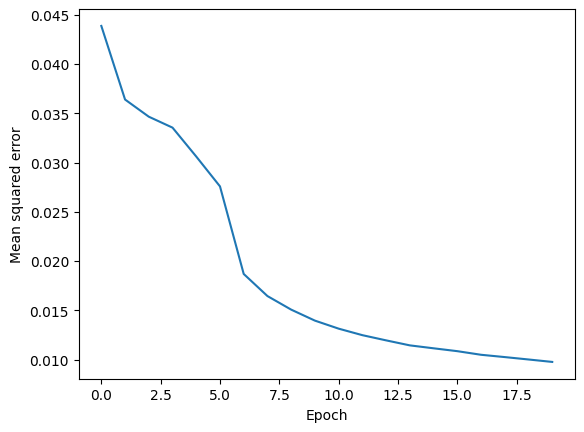

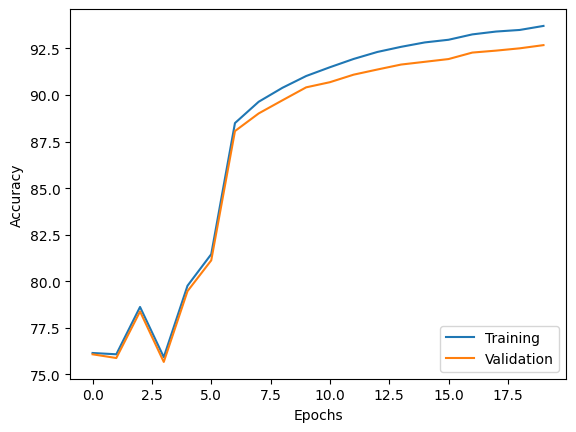

In [27]:
plt.plot(range(len(acc_epoch_loss)), acc_epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

plt.plot(range(len(acc_epoch_train_acc)), acc_epoch_train_acc,
         label='Training')
plt.plot(range(len(acc_epoch_valid_acc)), acc_epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# 1. Prepare Data
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

# 2. Updated Architecture (Two Hidden Layers)
class PyTorchMLP(nn.Module):
    def __init__(self):
        super(PyTorchMLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 500),
            nn.Sigmoid(),
            nn.Linear(500, 500), # Second Hidden Layer
            nn.Sigmoid(),
            nn.Linear(500, 10),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.layers(x)

model_pt = PyTorchMLP()
criterion = nn.MSELoss()
optimizer = optim.SGD(model_pt.parameters(), lr=0.1)

# 4. Training Loop
print("Training PyTorch Model...")
epochs = 50
for epoch in range(epochs):
    model_pt.train()
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model_pt(batch_X)
        
        # FIX: One-hot encode labels for MSELoss
        # This converts [batch_size] to [batch_size, 10]
        y_onehot = F.one_hot(batch_y, num_classes=10).float()
        
        loss = criterion(outputs, y_onehot)
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{epochs} complete.")

# 5. Evaluation
model_pt.eval()
with torch.no_grad():
    # model_pt already returns probabilities because of the final Softmax layer
    y_probs_pt = model_pt(X_test_tensor).numpy()
    y_pred_pt = np.argmax(y_probs_pt, axis=1)

auc_pt = roc_auc_score(y_test, y_probs_pt, multi_class='ovr', average='macro')
acc_pt = accuracy_score(y_test, y_pred_pt)

print(f"\nPyTorch Accuracy: {acc_pt*100:.2f}% | PyTorch Macro AUC: {auc_pt:.4f}")

Training PyTorch Model...
Epoch 5/50 complete.
Epoch 10/50 complete.
Epoch 15/50 complete.
Epoch 20/50 complete.
Epoch 25/50 complete.
Epoch 30/50 complete.
Epoch 35/50 complete.
Epoch 40/50 complete.
Epoch 45/50 complete.
Epoch 50/50 complete.

PyTorch Accuracy: 89.89% | PyTorch Macro AUC: 0.9899


In [ ]:
plt.plot(range(len(acc_epoch_loss)), acc_epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()